# Load and install all dependicies

In [1]:
!pip install numpy
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [2]:
!wandb login de83b34df4865f6d73caa690771345a92e44bb2d

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [3]:
!git clone https://github.com/OscarOvanger/GeoDecepticon.git

Cloning into 'GeoDecepticon'...
remote: Enumerating objects: 20272, done.
remote: Counting objects: 100% (334/334), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 20272 (delta 263), reused 171 (delta 171), pack-reused 19938 (from 5)
Receiving objects: 100% (20272/20272), 162.39 MiB | 6.09 MiB/s, done.
Resolving deltas: 100% (567/567), done.
Updating files: 100% (83/83), done.


In [4]:
import os
os.chdir('/content/GeoDecepticon')

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import wandb
import os
from tqdm.notebook import tqdm
import copy
from ViT import *
from ViT_sampling import *
from training import *
#from sampling import *
from tqdm import tqdm  # For progress bars
import time

# Load and plot training data

(9000, 64, 64)


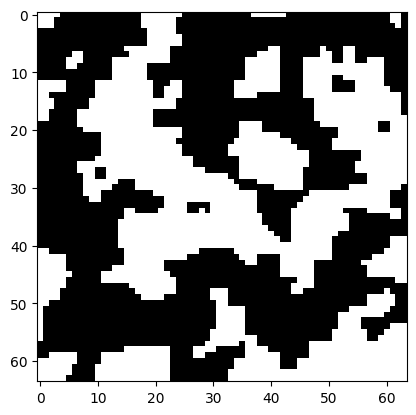

In [6]:
arr = np.load("Data/Markov_field/training_data_mod.npz")["arr_0"]
training_data = arr[:9000]
test_data = arr[9000:]
# We reshape it to 60x60 dataset
training_data = training_data.reshape(-1, 64, 64)
test_data = test_data.reshape(-1, 64, 64)
print(training_data.shape)
training_data = torch.tensor(training_data,dtype=torch.float32)
sanity_check_data = training_data[:10]
test_data = torch.tensor(test_data,dtype=torch.float32)
#plot the first data
plt.imshow(training_data[100],cmap='gray')
plt.show()

# Condition data

In [7]:
"""
condition_indices = np.array([876,3825,2122,2892,1556,2683,3667,1767,483,2351,
                                2000,3312,2953,289,2373,2720,872,2713,1206,1341,
                                3541,2226,3423,1904,2882,2540,1497,2524,264,1441])
condition_values = np.array([0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,
                              1,1,1,0,1,0,1,1,0,1])
condition_indices_x = condition_indices // 64
condition_indices_y = condition_indices % 64
print(condition_indices_x)
print(condition_indices_y)
plt.imshow(training_data[0],cmap='gray')
plt.scatter(condition_indices_y,condition_indices_x,c=condition_values,cmap='viridis')
plt.show()
"""

"\ncondition_indices = np.array([876,3825,2122,2892,1556,2683,3667,1767,483,2351,\n                                2000,3312,2953,289,2373,2720,872,2713,1206,1341,\n                                3541,2226,3423,1904,2882,2540,1497,2524,264,1441])\ncondition_values = np.array([0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,\n                              1,1,1,0,1,0,1,1,0,1])\ncondition_indices_x = condition_indices // 64\ncondition_indices_y = condition_indices % 64\nprint(condition_indices_x)\nprint(condition_indices_y)\nplt.imshow(training_data[0],cmap='gray')\nplt.scatter(condition_indices_y,condition_indices_x,c=condition_values,cmap='viridis')\nplt.show()\n"

[13 39 44 48 41 33 15 17 47 16 18 46  4 42 28]
[38 29 43 55 25 59 49  7 16 14 20 22 51 60 23]


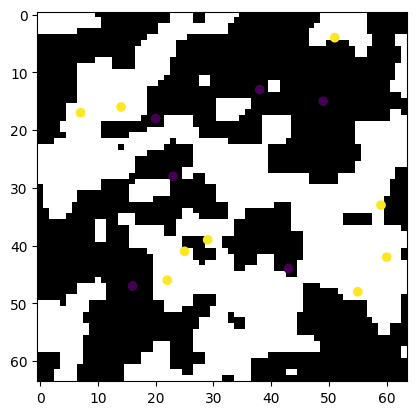

In [8]:
condition_indices_new = np.array([1726,3797,4211,4543,3953,3347,1897,2015,4424,1942,2108,4350,1019,4068,2911])
condition_values_new = np.array([0,1,0,1,1,1,0,1,0,1,0,1,1,1,0])
condition_indices_x = (condition_indices_new // 80) - 8
condition_indices_y = (condition_indices_new % 80) - 8
print(condition_indices_x)
print(condition_indices_y)
cond_data = np.load("Data/Markov_field/training_data_mod_cond.npz")["arr_0"]
plt.imshow(cond_data[105],cmap='gray')
plt.scatter(condition_indices_y,condition_indices_x,c=condition_values_new,cmap='viridis')
plt.show()

# Train Model

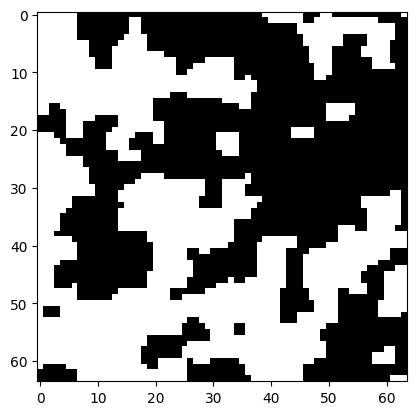

In [17]:
samps = np.load("cond_images_combined.npy")
plt.imshow(samps[2],cmap='gray')
plt.show()

In [9]:
# Try training for, say, 500 epochs; you can also try mask_rate=1.0 for a stricter overfit test.
nr_epochs = 1000
batch_size = 100
mask_rate = 0.01  # Try also mask_rate = 1.0 to check if the network can memorize given only positional cues.
final_mask_rate = 0.99
mask_schedule = "cyclic"
patch_size = 4
num_heads = 2
num_layers = 2
ffn_dim = 256
emb_dim = 64
learning_rate = 1e-3
vocab_cap = 100000

# Assume training_data is already defined with shape (N, H, W)
N, H, W = training_data.shape

# Set parameters.
vocab, counts, mask_token = build_vocabulary(training_data, patch_size, cap_size=vocab_cap)
patch_dim = patch_size ** 2
num_patches = (H // patch_size) ** 2

#samps = torch.tensor(samps,dtype=torch.float32)

flattened_condition_indices = np.zeros(len(condition_indices_new))
for i in range(len(condition_indices_new)):
    flattened_condition_indices[i] = condition_indices_x[i] * 64 + condition_indices_y[i]
flattened_condition_indices = flattened_condition_indices.astype(int)

# Create the model and load weights.
PATH = "Models/BEST_MODEL.pth"
model = StackedContextViT(
    vocab=vocab,
    mask_token=mask_token,
    patch_dim=patch_dim,
    num_patches=num_patches,
    emb_dim=emb_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    ffn_dim=ffn_dim,
    use_pos_emb=False,          # <— must be True to load the old 256×64 buffer
    use_rel_bias=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(PATH, map_location=device))  # remove weights_only if not applicable
"""
trained_model = run_training(training_data, nr_epochs, batch_size, mask_rate,
                 final_mask_rate, mask_schedule, patch_size, num_heads,
                 num_layers, ffn_dim, learning_rate, emb_dim, vocab_cap,pretrained=model,
                 use_pos_emb=False,use_rel_bias=True,rel_bias=model.rel_bias_table)
"""

'\ntrained_model = run_training(training_data, nr_epochs, batch_size, mask_rate, \n                 final_mask_rate, mask_schedule, patch_size, num_heads, \n                 num_layers, ffn_dim, learning_rate, emb_dim, vocab_cap,pretrained=model, \n                 use_pos_emb=False,use_rel_bias=True,rel_bias=model.rel_bias_table)\n'

In [11]:
model

StackedContextViT(
  (patch_proj): Linear(in_features=16, out_features=64, bias=True)
  (out_drop): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0-1): 2 x TransformerEncoderBlock(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (drop1): Dropout(p=0.1, inplace=False)
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=256, out_features=64, bias=True)
        (4): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (out_proj): Linear(in_features=64, out_features=5485, bias=True)
)

In [12]:
import torch

ckpt_path = "Models/BEST_MODEL.pth"
ckpt = torch.load(ckpt_path, map_location="cpu")

print("=== CHECKPOINT PARAMS ===")
for k, v in ckpt.items():
    # some entries in a checkpoint might be nested dicts (e.g. optimizer states)
    # we only want the tensors, so check isinstance(v, torch.Tensor)
    if isinstance(v, torch.Tensor):
        print(f"{k:40s}  {tuple(v.shape)}  dtype={v.dtype}")
    else:
        print(f"{k:40s}  (type={type(v)})")

=== CHECKPOINT PARAMS ===
mask_token                                (16,)  dtype=torch.float32
rel_bias_table                            (31, 31)  dtype=torch.float32
pos_emb                                   (1,)  dtype=torch.float32
patch_proj.weight                         (64, 16)  dtype=torch.float32
patch_proj.bias                           (64,)  dtype=torch.float32
layers.0.attn.in_proj_weight              (192, 64)  dtype=torch.float32
layers.0.attn.in_proj_bias                (192,)  dtype=torch.float32
layers.0.attn.out_proj.weight             (64, 64)  dtype=torch.float32
layers.0.attn.out_proj.bias               (64,)  dtype=torch.float32
layers.0.norm1.weight                     (64,)  dtype=torch.float32
layers.0.norm1.bias                       (64,)  dtype=torch.float32
layers.0.ffn.0.weight                     (256, 64)  dtype=torch.float32
layers.0.ffn.0.bias                       (256,)  dtype=torch.float32
layers.0.ffn.3.weight                     (64, 256)  dtype=

In [9]:
# Assume training_data is already defined with shape (N, H, W)
N, H, W = training_data.shape

# Set parameters.
vocab, counts, mask_token = build_vocabulary(training_data, patch_size, cap_size=vocab_cap)
patch_dim = patch_size ** 2
num_patches = (H // patch_size) ** 2

#samps = torch.tensor(samps,dtype=torch.float32)

flattened_condition_indices = np.zeros(len(condition_indices_new))
for i in range(len(condition_indices_new)):
    flattened_condition_indices[i] = condition_indices_x[i] * 64 + condition_indices_y[i]
flattened_condition_indices = flattened_condition_indices.astype(int)

# Create the model and load weights.
PATH = "Models/BEST_MODEL.pth"
model = StackedContextViT(
    vocab=vocab,
    mask_token=mask_token,
    patch_dim=patch_dim,
    num_patches=num_patches,
    emb_dim=emb_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    ffn_dim=ffn_dim,
    use_pos_emb=False,          # <— must be True to load the old 256×64 buffer
    use_rel_bias=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(PATH, map_location=device))  # remove weights_only if not applicable
"""
model.to(device)
model.vocab = model.vocab.to(device)
model.mask_token = model.mask_token.to(device)
images,ll = generate_images_batch(model, patch_size, image_size=H, batch_size=3,device=device,
                          condition_indices=flattened_condition_indices, condition_values=condition_values_new,
                          generation_order="manhattan")
plt.imshow(images[0],cmap='gray')
plt.title(f"ll: {ll[0]}")
plt.show()
images = images.to(device)
ll_new = log_likelihood_evaluation_batch(
    model,
    images,            # tensor [B, H, W] of binary images
    patch_size,              # int
    condition_indices=flattened_condition_indices,
    condition_values=condition_values_new,
    generation_order="manhattan"
)
print(f"ll_new: {ll_new[0]}")
samps = samps.to(device)
ll_VEA_full = []
for i in range(30):
  ll_VEA = log_likelihood_evaluation_batch(
      model,
      samps[i*100:(i+1)*100],            # tensor [B, H, W] of binary images
      patch_size,              # int
      condition_indices=flattened_condition_indices,
      condition_values=condition_values_new,
      generation_order="manhattan"
  )
  ll_VEA_full.append(ll_VEA)
print(ll_VEA)
"""

NameError: name 'patch_size' is not defined

In [10]:
import math
import torch
import torch.nn.functional as F

def compute_log_likelihood_batch(
    model,
    device,
    image_batches,
    condition_indices=None,
    condition_values=None,
    generation_order="manhattan",
    atol=1e-6
):
    """
    Compute sum of log-likelihoods for a batch of fully-observed images under
    the masked‐patch sequential model, following the specified generation_order.

    Args:
        model:            PyTorch model with attributes
                          - .vocab       (Tensor[V, D])
                          - .mask_token  (Tensor[D])
                          and callable forward(inputs, mask_rate=0.0) -> (logits, _)
        device:           torch device (e.g. "cuda")
        image_batches:    FloatTensor of shape [B, H, W], values in [0,1]
        condition_indices: List of flattened pixel indices to treat as
                           additional observed constraints (shared across batch)
        condition_values:  List of 0/1 values for those indices
        generation_order:  One of "raster", "manhattan", "inverse manhattan"
        atol:             Tolerance for matching patch vectors to vocab

    Returns:
        log_likelihoods:  FloatTensor of shape [B], sum of per-patch log-probs
    """
    model.to(device)
    model.eval()
    image_batches = image_batches.to(device)
    B, H, W = image_batches.shape
    # infer patch size & grid
    D = model.mask_token.shape[0]
    P = int(math.sqrt(D))
    assert P*P == D, "mask_token dim not a square"
    assert H == W and H % P == 0, "image size must be divisible by patch_size"
    G = H // P
    T = G * G

    # pull out true patch vectors: [B, T, D]
    patches = (
        image_batches
        .unfold(1, P, P)          # -> [B, G, W, P]
        .unfold(2, P, P)          # -> [B, G, G, P, P]
        .permute(0,1,2,3,4)       # ensure layout
        .contiguous()
        .view(B, T, D)
    )

    # build patch-level condition map
    conditions_by_patch = {}
    if condition_indices is not None and condition_values is not None:
        for pix_idx, pix_val in zip(condition_indices, condition_values):
            pr, pc = divmod(pix_idx, H)
            pr0, pc0 = pr // P, pc // P
            pidx = pr0 * G + pc0
            local = (pr % P)*P + (pc % P)
            conditions_by_patch.setdefault(pidx, []).append((local, pix_val))

    # figure out sampling order
    observed = sorted(conditions_by_patch.keys())
    all_p   = set(range(T))
    unobs   = list(all_p - set(observed))

    if generation_order == "raster":
        unobs.sort()
    elif generation_order == "manhattan":
        if observed:
            dist = []
            for p in unobs:
                r,c = divmod(p, G)
                s = sum(abs(r - (o//G)) + abs(c - (o%G)) for o in observed)
                dist.append((p,s))
            unobs = [p for p,_ in sorted(dist, key=lambda x: x[1])]
        else:
            unobs.sort()
    elif generation_order == "inverse manhattan":
        if observed:
            inv = []
            for p in unobs:
                r,c = divmod(p, G)
                s = sum(1.0/(abs(r-(o//G))+abs(c-(o%G))) for o in observed)
                inv.append((p,s))
            unobs = [p for p,_ in sorted(inv, key=lambda x: x[1], reverse=True)]
        else:
            unobs.sort()
    else:
        raise ValueError(f"Unknown generation_order {generation_order}")

    sampling_order = observed + unobs

    # prepare storage
    log_likes = torch.zeros(B, device=device)
    mask_tok  = model.mask_token.detach().to(device)      # [D]
    vocab     = model.vocab.to(device)                    # [V, D]
    V         = vocab.shape[0]

    # initially mask all patches
    generated = mask_tok.unsqueeze(0).unsqueeze(0)\
                   .expand(B, T, D).clone()

    # sequentially fill in actual patches, accumulating log‐probs
    for p in sampling_order:
        with torch.no_grad():
            logits_full, _ = model(generated.to(device), mask_rate=0.0)
        # logits for this patch: [B, V]
        logits_p = logits_full[:, p, :]

        # apply any patch‐level condition constraints
        if p in conditions_by_patch:
            valid = torch.ones(V, dtype=torch.bool, device=device)
            for local_i, val in conditions_by_patch[p]:
                valid &= (vocab[:, local_i] == val)
            logits_p = logits_p.masked_fill(~valid.unsqueeze(0), -float('inf'))

        # compute probabilities
        probs_p = F.softmax(logits_p, dim=-1)  # [B, V]

        # find the true token index for each image in batch
        # compare vocab rows to the true patch vector
        # -> [B, V, D] difference, then match along D
        diff    = vocab.unsqueeze(0) - patches[:, p, :].unsqueeze(1)  # [B, V, D]
        matches = torch.all(torch.abs(diff) < atol, dim=2)           # [B, V]
        # argmax gives first True index (we assume every patch is in vocab)
        true_idx = matches.float().argmax(dim=1)                      # [B]

        # gather the probability assigned to the true token, accumulate
        p_true = probs_p[torch.arange(B, device=device), true_idx]
        log_likes += torch.log(p_true + 1e-10)

        # now “fill in” that patch with the true vocab vector
        generated[:, p, :] = vocab[true_idx]

    return log_likes

In [11]:
arr = np.load("Data/Markov_field/training_data_mod_cond.npz")["arr_0"]
manhattan_img = np.load('cond_images_manhattan (3).npy')
inv_manhattan_img = np.load('reverse_manhattan_images.npy')
manhattan_img_temp = np.load('manhattan_images.npy')
inv_manhattan_img_temp = np.load('reverse_manhattan_images (1).npy')
samps = np.concatenate((arr,manhattan_img,inv_manhattan_img,manhattan_img_temp,inv_manhattan_img_temp))
samps = np.array(samps)
samps.shape

(5000, 64, 64)

In [13]:
log_lik_list = []
for i in range(500):
  curr_batch = samps[i*10:(i+1)*10]
  curr_batch = torch.tensor(curr_batch,dtype=torch.float32).to(device)
  log_lik = compute_log_likelihood_batch(
      model,
      device,
      curr_batch,
      condition_indices=flattened_condition_indices,
      condition_values=condition_values_new,
      generation_order="manhattan",
      atol=1e-6
  )
  log_lik_list.append(log_lik)
  print(f"sampled {i+1} out of 500")
#print(log_lik_list)
# Convert to numpy array
log_lik_array = np.array(log_lik_list)
# save numpy array
np.save("log_lik_array_all_samples_manhattan.npy", log_lik_array)

sampled 1 out of 500
sampled 2 out of 500
sampled 3 out of 500
sampled 4 out of 500
sampled 5 out of 500
sampled 6 out of 500
sampled 7 out of 500
sampled 8 out of 500
sampled 9 out of 500


KeyboardInterrupt: 

In [14]:
model.to(device)
model.vocab = model.vocab.to(device)
model.mask_token = model.mask_token.to(device)
reverse_manhattan_images = []
reverse_manhattan_lls = []
for i in range(10):
  images,ll = generate_images_batch(model, patch_size, image_size=H, batch_size=100,device=device,
                          condition_indices=flattened_condition_indices, condition_values=condition_values_new,
                          generation_order="manhattan",temperature=0.9)
  images = images.cpu().detach().numpy()
  reverse_manhattan_images.append(images)
  reverse_manhattan_lls.append(ll)

In [15]:
reverse_manhattan_images = np.concatenate(reverse_manhattan_images,axis=0)
reverse_manhattan_lls = np.concatenate(reverse_manhattan_lls,axis=0)

In [16]:
np.save("manhattan_images.npy",reverse_manhattan_images)
np.save("manhattan_lls.npy",reverse_manhattan_lls)

In [35]:
import io
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
import imageio

# -------------------------------------------------------------------
# 0) Ensure you have your `patches_to_image` helper in scope:
# -------------------------------------------------------------------
# def patches_to_image(patches_tensor, image_size, patch_size):
#     # your implementation here
#     ...

# -------------------------------------------------------------------
# 1) Hook for capturing real soft‐attention weights
# -------------------------------------------------------------------
attn_store = []
def _attn_hook(module, inp, out):
    # out = (attn_output, attn_output_weights)
    attn_store.append(out[1].detach())
# register on each MultiheadAttention
for layer in model.layers:
    layer.attn.register_forward_hook(_attn_hook)

# -------------------------------------------------------------------
# 2) Helper functions
# -------------------------------------------------------------------
def add_colored_border(token, border_width=1, border_color=(1, 0, 0)):
    token_rgb = np.stack([token]*3, axis=-1)
    H, W, _ = token_rgb.shape
    new_H, new_W = H + 2*border_width, W + 2*border_width
    bordered = np.ones((new_H, new_W, 3)) * 0.5
    bordered[border_width:border_width+H, border_width:border_width+W] = token_rgb
    bordered[:border_width, :] = border_color
    bordered[-border_width:, :] = border_color
    bordered[:, :border_width] = border_color
    bordered[:, -border_width:] = border_color
    return bordered

def fig_to_np(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    return np.array(Image.open(buf).convert("RGB"))

# -------------------------------------------------------------------
# 3) Full generate_video() with temperature parameter
# -------------------------------------------------------------------
def generate_video(
    model,
    patch_size,
    image_size,
    condition_indices=None,
    condition_values=None,
    topk=10,
    temperature=1.0,
    video_filename="generation_with_attn.mp4",
    fps=4,
    generation_order="manhattan",
    given_image=None,
):
    device = next(model.parameters()).device
    model.eval()

    grid = image_size // patch_size
    T = grid * grid
    D = patch_size * patch_size
    V = model.vocab.size(0)

    # scatter coords
    if condition_indices is not None:
        ys = condition_indices // image_size
        xs = condition_indices % image_size

    # initialize states
    mask_tok  = model.mask_token.detach().to(device)
    gen_state = mask_tok.unsqueeze(0).expand(T, D).clone()
    gt_state  = mask_tok.unsqueeze(0).expand(T, D).clone()
    done      = torch.zeros(T, dtype=torch.bool, device=device)

    # ground‐truth patches
    if given_image is not None:
        gimg = (torch.from_numpy(given_image)
                if isinstance(given_image, np.ndarray)
                else given_image).to(device)
        g_patches = []
        for p in range(T):
            r0 = (p//grid)*patch_size
            c0 = (p%grid)*patch_size
            g_patches.append(gimg[r0:r0+patch_size, c0:c0+patch_size].reshape(-1))
        g_patches = torch.stack(g_patches)
    else:
        g_patches = None

    # conditions per patch
    conditions = {}
    if condition_indices is not None and condition_values is not None:
        for pix, val in zip(condition_indices, condition_values):
            pr, pc = divmod(pix, image_size)
            pidx = (pr//patch_size)*grid + (pc//patch_size)
            lidx = (pr % patch_size)*patch_size + (pc % patch_size)
            conditions.setdefault(pidx, []).append((lidx, val))

    # sampling order
    observed = sorted(conditions.keys())
    unobs    = list(set(range(T)) - set(observed))
    if generation_order == "raster":
        unobs.sort()
    elif generation_order == "manhattan":
        dist = [(p, sum(abs(p//grid - o//grid) + abs(p%grid - o%grid) for o in observed)) for p in unobs]
        unobs = [p for p,_ in sorted(dist, key=lambda x: x[1])]
    elif generation_order == "inverse manhattan":
        inv  = [(p, sum(1.0/(abs(p//grid - o//grid) + abs(p%grid - o%grid)) for o in observed)) for p in unobs]
        unobs = [p for p,_ in sorted(inv, key=lambda x: x[1], reverse=True)]
    else:
        raise ValueError(f"Unknown generation_order {generation_order}")
    order = observed + unobs

    # accumulators
    acc_ll_gen = acc_ll_gt = 0.0
    mode_count_gen = mode_count_gt = 0

    frames = []
    scatter_cmap = ListedColormap(["blue","red"])

    for step, pidx in enumerate(tqdm(order, desc="Sampling")):
        # 1) capture gen attentions
        attn_store.clear()
        logits_gen, _ = model(gen_state.unsqueeze(0), mask_rate=0.0)
        attn_weights_gen = torch.stack(attn_store, dim=0)[:, 0]  # [layers, T, T]

        # 2) capture given attentions
        attn_store.clear()
        logits_gt, _ = model(gt_state.unsqueeze(0), mask_rate=0.0)
        attn_weights_gt = torch.stack(attn_store, dim=0)[:, 0]

        # 3) build log‐attention maps
        eps = 1e-12
        avg_gen = attn_weights_gen.mean(dim=0)[pidx]
        norm_gen = avg_gen / avg_gen.sum()
        log_gen  = torch.log(norm_gen + eps)
        attn_map_gen = log_gen.reshape(grid, grid).cpu().detach().numpy()

        avg_gt  = attn_weights_gt.mean(dim=0)[pidx]
        norm_gt = avg_gt / avg_gt.sum()
        log_gt  = torch.log(norm_gt + eps)
        attn_map_gt  = log_gt.reshape(grid, grid).cpu().detach().numpy()

        # 4) sample & ll with temperature
        # apply temperature only to generated sampling
        logits_t = logits_gen[0, pidx] / temperature
        probs_gen = F.softmax(logits_t, dim=-1)
        probs_gt  = F.softmax(logits_gt[0, pidx],  dim=-1)

        if pidx in conditions:
            valid = torch.ones(V, dtype=torch.bool, device=device)
            for li, val in conditions[pidx]:
                valid &= (model.vocab[:, li] == val)
            probs_gen = probs_gen.masked_fill(~valid, 0)
            probs_gt  = probs_gt.masked_fill(~valid, 0)
            probs_gen /= probs_gen.sum()
            probs_gt  /= probs_gt.sum()

        tok_gen = torch.multinomial(probs_gen, 1).item()
        acc_ll_gen += float(torch.log(probs_gen[tok_gen] + 1e-10))
        gen_state[pidx] = model.vocab[tok_gen]
        if tok_gen == int(torch.argmax(probs_gen)):
            mode_count_gen += 1

        if g_patches is not None:
            dists   = ((model.vocab.to(device) - g_patches[pidx].unsqueeze(0))**2).sum(-1)
            idx_gt  = int(torch.argmin(dists))
            acc_ll_gt += float(torch.log(probs_gt[idx_gt] + 1e-10))
            gt_state[pidx] = model.vocab[idx_gt]
            if idx_gt == int(torch.argmax(probs_gt)):
                mode_count_gt += 1
        else:
            idx_gt = None

        done[pidx] = True

        # topk arrays
        topk_inds_gen = torch.topk(probs_gen, topk).indices.cpu().detach().numpy()
        topk_vals_gen = probs_gen[topk_inds_gen].cpu().detach().numpy()
        topk_inds_gt  = torch.topk(probs_gt, topk).indices.cpu().detach().numpy()
        topk_vals_gt  = probs_gt[topk_inds_gt].cpu().detach().numpy()

        # 5) plot 2×5 grid
        fig, axs = plt.subplots(2, 5, figsize=(40, 16))

        # Given Context + scatter
        disp_gt = [gt_state[i] if done[i] else torch.full((D,), 0.5, device=device) for i in range(T)]
        img_gt  = patches_to_image(torch.stack(disp_gt), (image_size, image_size), patch_size)
        axs[0,0].imshow(img_gt.cpu(), cmap="gray", vmin=0, vmax=1)
        if condition_indices is not None:
            axs[0,0].scatter(xs, ys, c=condition_values, cmap=scatter_cmap, s=20, edgecolors="white")
        axs[0,0].add_patch(mpatches.Rectangle(
            ((pidx%grid)*patch_size - .5, (pidx//grid)*patch_size - .5),
            patch_size, patch_size, linewidth=2, edgecolor="green", facecolor="none"
        ))
        axs[0,0].set_title("Given Context"); axs[0,0].axis("off")

        # Given log‐attention + highlight + colorbar
        im0 = axs[0,1].imshow(attn_map_gt, cmap="viridis", vmin=-15, vmax=0)
        r, c = divmod(pidx, grid)
        axs[0,1].add_patch(mpatches.Rectangle(
            (c - .5, r - .5), 1, 1, linewidth=2, edgecolor="green", facecolor="none"
        ))
        axs[0,1].set_title("Given log-Attention"); axs[0,1].axis("off")
        fig.colorbar(im0, ax=axs[0,1], fraction=0.046, pad=0.04)

        # P on Given
        colors_gt = ["purple"]*topk
        if idx_gt is not None:
            for i, tid in enumerate(topk_inds_gt):
                if tid == idx_gt:
                    colors_gt[i] = "orange"
        axs[0,2].bar(np.arange(topk), topk_vals_gt, color=colors_gt)
        axs[0,2].set_xticks(np.arange(topk)); axs[0,2].set_xticklabels(topk_inds_gt, fontsize=12)
        axs[0,2].set_ylim(0,1); axs[0,2].set_title("P on Given")

        # Top-10 Given tokens
        giv_tiles = [model.vocab[int(tid)].cpu().reshape(patch_size,patch_size).numpy() for tid in topk_inds_gt]
        giv_grid  = np.hstack([add_colored_border(t,1,(1,0.5,0)) for t in giv_tiles])
        axs[0,3].imshow(giv_grid, cmap="gray", vmin=0, vmax=1); axs[0,3].axis("off"); axs[0,3].set_title("Top-10 Given")

        # Given patch w/ stats
        if idx_gt is not None:
            arr_gt = model.vocab[idx_gt].cpu().reshape(patch_size,patch_size).numpy()
            axs[0,4].imshow(add_colored_border(arr_gt,1,(1,0.5,0)), cmap="gray", vmin=0, vmax=1)
            axs[0,4].axis("off")
            axs[0,4].set_title(f"p={probs_gt[idx_gt]:.3f}\nΣ_ll={acc_ll_gt:.3f}\nmode_cnt={mode_count_gt}")
        else:
            axs[0,4].axis("off")

        # Gen Context + scatter
        disp_gen = [gen_state[i] if done[i] else torch.full((D,), 0.5, device=device) for i in range(T)]
        img_gen  = patches_to_image(torch.stack(disp_gen), (image_size, image_size), patch_size)
        axs[1,0].imshow(img_gen.cpu(), cmap="gray", vmin=0, vmax=1)
        if condition_indices is not None:
            axs[1,0].scatter(xs, ys, c=condition_values, cmap=scatter_cmap, s=20, edgecolors="white")
        axs[1,0].add_patch(mpatches.Rectangle(
            ((pidx%grid)*patch_size - .5, (pidx//grid)*patch_size - .5),
            patch_size, patch_size, linewidth=2, edgecolor="green", facecolor="none"
        ))
        axs[1,0].set_title("Gen Context"); axs[1,0].axis("off")

        # Gen log-attention + highlight + colorbar
        im1 = axs[1,1].imshow(attn_map_gen, cmap="viridis", vmin=-15, vmax=0)
        axs[1,1].add_patch(mpatches.Rectangle(
            (c - .5, r - .5), 1, 1, linewidth=2, edgecolor="green", facecolor="none"
        ))
        axs[1,1].set_title("Gen log-Attention"); axs[1,1].axis("off")
        fig.colorbar(im1, ax=axs[1,1], fraction=0.046, pad=0.04)

        # P on Generated
        colors_gen = ["purple"]*topk
        for i, tid in enumerate(topk_inds_gen):
            if tid == tok_gen:
                colors_gen[i] = "green"
        axs[1,2].bar(np.arange(topk), topk_vals_gen, color=colors_gen)
        axs[1,2].set_xticks(np.arange(topk)); axs[1,2].set_xticklabels(topk_inds_gen, fontsize=12)
        axs[1,2].set_ylim(0,1); axs[1,2].set_title("P on Generated")

        # Top-10 Gen tokens
        samp_tiles = [model.vocab[int(tid)].cpu().reshape(patch_size,patch_size).numpy() for tid in topk_inds_gen]
        samp_grid  = np.hstack([add_colored_border(t,1,(0,1,0)) for t in samp_tiles])
        axs[1,3].imshow(samp_grid, cmap="gray", vmin=0, vmax=1); axs[1,3].axis("off"); axs[1,3].set_title("Top-10 Gen")

        # Gen patch w/ stats
        arr_gen = model.vocab[tok_gen].cpu().reshape(patch_size,patch_size).numpy()
        axs[1,4].imshow(add_colored_border(arr_gen,1,(0,1,0)), cmap="gray", vmin=0, vmax=1)
        axs[1,4].axis("off")
        axs[1,4].set_title(f"p={probs_gen[tok_gen]:.3f}\nΣ_ll={acc_ll_gen:.3f}\nmode_cnt={mode_count_gen}")

        plt.suptitle(f"Step {step}, Patch {pidx}")
        frames.append(fig_to_np(fig))
        plt.close(fig)

    imageio.mimwrite(video_filename, frames, fps=fps)
    print(f"Saved {video_filename}")

    final = patches_to_image(gen_state.cpu(), (image_size, image_size), patch_size)
    return final, acc_ll_gen, acc_ll_gt, mode_count_gen, mode_count_gt



In [39]:
img, ll_sample, ll_given,mode_sample,mode_given = generate_video(model,patch_size,image_size=H,condition_indices=flattened_condition_indices,condition_values=condition_values_new,given_image=samps[334],generation_order="inverse manhattan", temperature=0.9)

Sampling: 100%|██████████| 256/256 [04:18<00:00,  1.01s/it]


Saved generation_with_attn.mp4


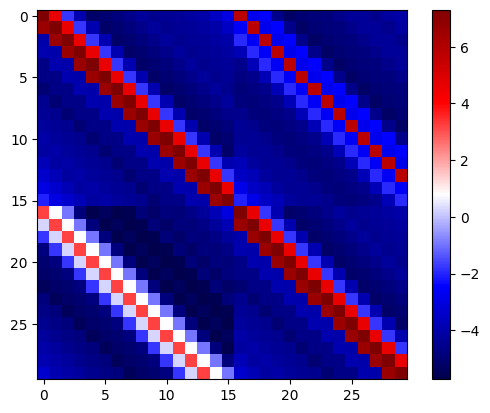

In [14]:
import torch

def stationary_to_full(rel_bias_table: torch.Tensor) -> torch.Tensor:
    """
    rel_bias_table: (2G-1, 2G-1) tensor of stationary biases
    returns: (G*G, G*G) full covariance matrix
    """
    # recover G
    D = rel_bias_table.shape[0]
    assert D % 2 == 1, "table must be odd-sized"
    G = (D + 1) // 2       # e.g. D=31 -> G=16
    N = G * G              # 256

    # compute patch grid coordinates 0..G-1
    idx = torch.arange(N)
    rows = idx // G        # shape (N,)
    cols = idx %  G        # shape (N,)

    # pairwise differences dr, dc in [-(G-1) .. (G-1)]
    dr = rows[:, None] - rows[None, :]   # (N, N)
    dc = cols[:, None] - cols[None, :]   # (N, N)

    # shift to [0 .. 2G-2] to index into rel_bias_table
    ir = dr + (G - 1)    # now in [0 .. 2G-2]
    ic = dc + (G - 1)

    # gather
    full = rel_bias_table[ir, ic]  # (N, N)
    return full

# example:
rel31 = model.rel_bias_table.cpu().detach().numpy()    # your learned table
full256 = stationary_to_full(rel31)
plt.imshow(full256[:30,:30],cmap="seismic")  # torch.Size([256, 256])
plt.colorbar()
plt.show()